In [207]:
import warnings
warnings.filterwarnings('ignore')

from scipy.io import readsav
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import astropy.constants as astro_const
from sunpy.coordinates import sun

import os
import sys
import glob
# Construct the full path to the scripts directory
script_path = os.path.abspath('./scripts')

# Add the scripts directory to sys.path
if script_path not in sys.path:
    sys.path.append(script_path)

import fwdtools as fwd
import solar_data_utils as myfuncs
# Reload to update with new changes
import importlib
importlib.reload(fwd)
importlib.reload(myfuncs)

plt.rcParams['figure.figsize'] = [7,7]
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.format'] = 'png'
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'white'

# set the directory path where the data is importe/stored
data_dir = '/home/mnedal/data'

In [234]:
obs_time = '2024-05-14 17:40:00'

# return the Carrington longitude (central meridian longitude) for a given datetime
clon = sun.L0(time=obs_time).value

# return the Carrington rotation number for a given datetime
crot = sun.carrington_rotation_number(t=obs_time)

# return the datetime for a given Carrington longitude (central meridian longitude)
cobstime = sun.carrington_rotation_time(crot=int(crot), longitude=clon*u.deg).iso

print(f'Carrington longitude: {clon}')
print(f'Carrington rotation number: {crot}')
print(f'Carrington observe time: {cobstime}')

Carrington longitude: 250.9526056369985
Carrington rotation number: 2284.3029094287863
Carrington observe time: 2024-05-14 17:39:59.946


In [232]:
sun.carrington_rotation_time(crot=int(crot), longitude=251.00361*u.deg).iso # the default value in FORWARD doesn not quite refer to the set datetime

'2024-05-14 17:34:26.741'

In [233]:
sun.carrington_rotation_time(crot=int(crot), longitude=249.71780*u.deg).iso # the default value in FORWARD doesn not quite refer to the set datetime

'2024-05-14 19:54:26.761'

In [206]:
file_paths = sorted(glob.glob(f'{data_dir}/FORWARD/*.sav'))
print(*file_paths, sep='\n')

/home/mnedal/data/FORWARD/psimas_PHYSICAL_DIAGNOSTICS_BETA_2460557.1712963disk.sav
/home/mnedal/data/FORWARD/psimas_PHYSICAL_DIAGNOSTICS_BMAG_2460557.0758218disk.sav
/home/mnedal/data/FORWARD/psimas_PHYSICAL_DIAGNOSTICS_DENS_2460557.0699769disk.sav


In [137]:
for file in file_paths:
    if 'BMAG' in file:
        bmag = fwd.get_forward_map(file)
    elif 'DENS' in file:
        dens = fwd.get_forward_map(file)
    elif 'BETA' in file:
        beta = fwd.get_forward_map(file)
    elif 

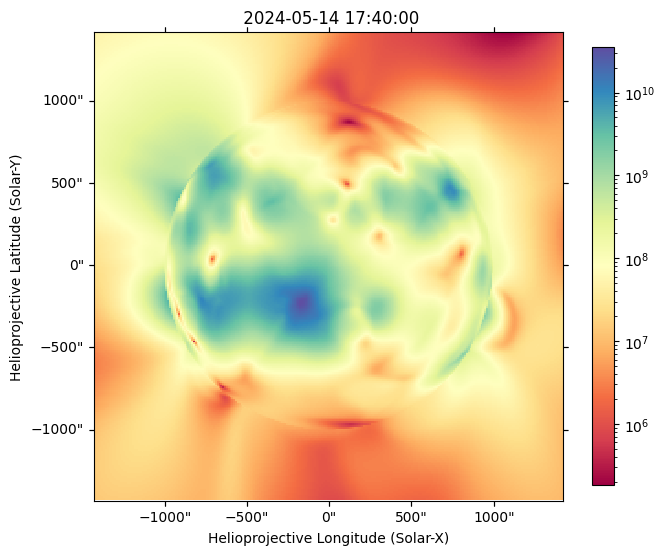

In [141]:
fig = plt.figure(figsize=[7,7])
ax = fig.add_subplot(projection=v_a)
img = v_a.plot(axes=ax,
                      # vmin=0.5e2, vmax=1e4,
                      norm=colors.LogNorm(),
                      # norm=colors.LogNorm(vmin=1e-2, vmax=1e2),
                      cmap='Spectral') # RdYlBu, Spectral
# v_a.draw_limb()
plt.colorbar(img, shrink=0.7, pad=0.05)
ax.grid(False)
fig.tight_layout()
plt.show()

In [ ]:
# [
#     'log(Density [cm$^{-3}$])',
#     'log(Temperature [K])',
#     'log(|B| [G])',
#     'log(Plasma Beta)'
#     'log($P_{total}$ [dynes/cm$^2$])',
#     '$V_{alfven}$ [km s$^{-1}$]'
# ]

In [194]:
# Calculate the Alfven speed map
mp = const.m_p.to(u.gram).value
valf = bmag.data/np.sqrt(4*np.pi*mp*dens.data)/1e4
VA = sunpy.map.Map(valf, dens.meta)

In [195]:
np.nanmax(VA.data), np.nanmin(VA.data)

(71494.60065970878, 52.635005562482334)

In [196]:
# My simplification ...
mp = const.m_p.to(u.gram).value
valf_cm_s = bmag.data/np.sqrt(4*np.pi*mp*dens.data)
valf_km_s = valf_cm_s * 1e-5
VA = sunpy.map.Map(valf_km_s, dens.meta)

In [197]:
np.nanmax(VA.data), np.nanmin(VA.data)

(7149.460065970879, 5.263500556248234)

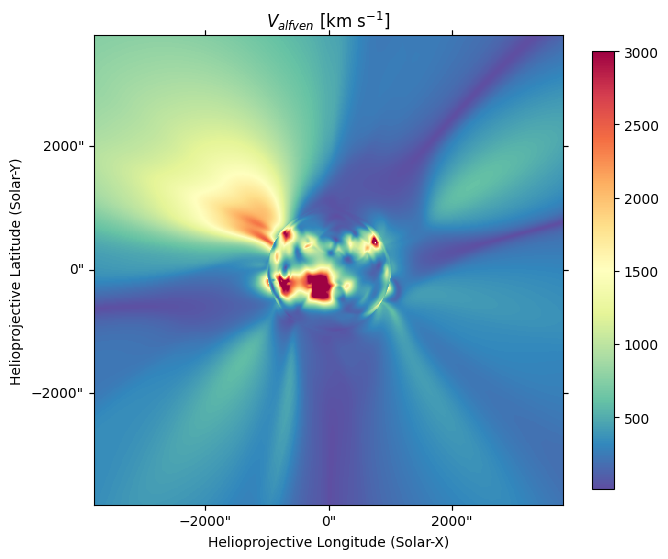

In [205]:
fig = plt.figure(figsize=[7,7])
ax = fig.add_subplot(projection=VA)
img = VA.plot(axes=ax, vmin=1e1, vmax=3e3, title='$V_{alfven}$ [km s$^{-1}$]', cmap='Spectral_r')
# VA.draw_limb()
plt.colorbar(img, ax=ax, shrink=0.7, pad=0.05)
ax.grid(False)
fig.tight_layout()
plt.show()

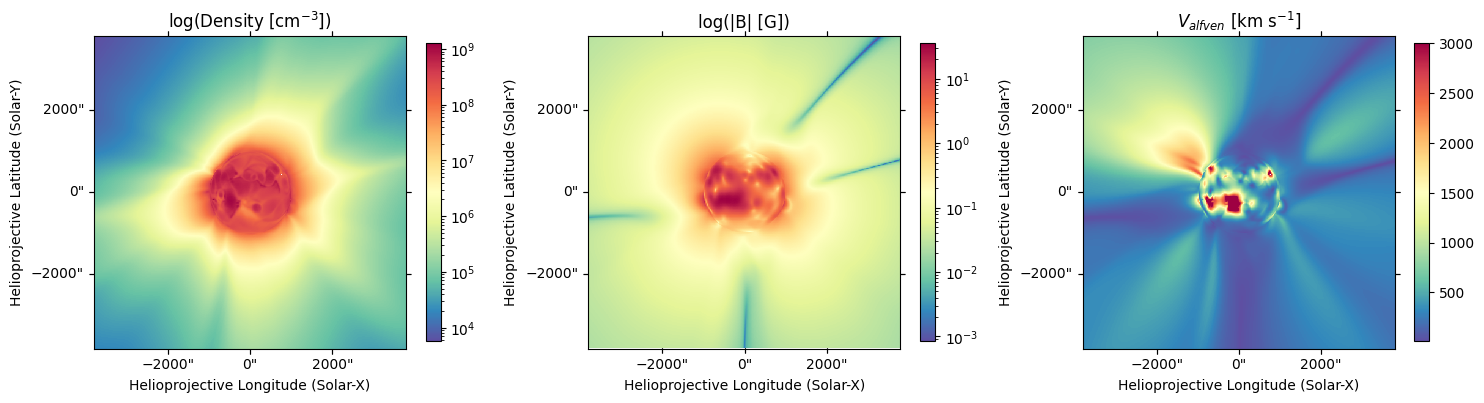

In [201]:
fig = plt.figure(figsize=[15,5])

ax = fig.add_subplot(131, projection=dens)
img = dens.plot(axes=ax,
                      # vmin=0.5e2, vmax=1e4,
                      norm=colors.LogNorm(),
                      # norm=colors.LogNorm(vmin=1e-2, vmax=1e2),
                title='log(Density [cm$^{-3}$])',
                      cmap='Spectral_r') # RdYlBu, Spectral
# v_a.draw_limb()
plt.colorbar(img, shrink=0.7, pad=0.05)
ax.grid(False)

ax = fig.add_subplot(132,projection=bmag)
img = bmag.plot(axes=ax,
                      # vmin=0.5e2, vmax=1e4,
                      norm=colors.LogNorm(),
                      # norm=colors.LogNorm(vmin=1e-2, vmax=1e2),
                title='log(|B| [G])',
                      cmap='Spectral_r') # RdYlBu, Spectral
# v_a.draw_limb()
plt.colorbar(img, shrink=0.7, pad=0.05)
ax.grid(False)

ax = fig.add_subplot(133, projection=VA)
img = VA.plot(axes=ax,
                      vmin=1e1, vmax=3e3,
                      # norm=colors.LogNorm(),
                      # norm=colors.LogNorm(vmin=1e-2, vmax=1e2),
              title='$V_{alfven}$ [km s$^{-1}$]',
                      cmap='Spectral_r') # RdYlBu, Spectral
# v_a.draw_limb()
plt.colorbar(img, shrink=0.7, pad=0.05)
ax.grid(False)

fig.tight_layout()
plt.show()

In [ ]:
# ###########################################################################
# #LOAD THE PSIMAS/FORWARD PLASMA DIAGNOSTICS
# diagnostics=['dens','temp','bmag','beta','ptot']
# diagmaps=[]
# for diagnostic in diagnostics:
#     psimas_diagfile = basedir+'psimas/psimas_diagnostic_'+diagnostic+'_'+psimas_date+'_'+psimasres+'.sav'
#     forwardmap = get_forward_map(psimas_diagfile)
#     mapsavefile = basedir+'psimas/psimas_diagnostic_map_'+diagnostic+'_'+psimas_date+'_'+psimasres+'.fits'
#     try: 
#         forwardmap.save(mapsavefile)
#     except:
#         pass
#     diagmaps.append(forwardmap)
#     forwardmap = None

# #Calculate the Alfven speed
# mp = 1.6726e-24
# valf = diagmaps[2].data/np.sqrt(4*np.pi*mp*diagmaps[0].data)/1.e4
# valfmap = sunpy.map.Map(valf, diagmaps[0].meta)
# diagnostic = 'valfven'
# mapsavefile = basedir+'psimas/psimas_diagnostic_map_'+diagnostic+'_'+psimas_date+'_'+psimasres+'.fits'
# try: 
#     valfmap.save(mapsavefile)
# except:
#     pass
# diagmaps.append(valfmap)

In [92]:
# ##############################################################################
# # We will first begin be reading in the header and data from the SAV file.
# hdul = readsav(file_paths[-1])

# #####################################################################################
# # The data in this file is in a datacube structure
# data = np.array(hdul['quantmap'].DATA[0])
# ###############################################################################
# # Lets pull out the observation time and quantity, we will use
# # these to create our new header.
# # Now we need to get the other parameters from the header that will be used
# # to create the new header - here we can get the cdelt1 and cdelt2 which are
# # the spatial scales of the data axes.

# pxrsun = hdul['quantmap'][0][4]
# obstime = str(hdul['quantmap'][0][5]).split('\'')[1] + 'T12:00:00'
# quantity = str(hdul['quantmap'][0][6]).split('!')[0].split('\'')[1]
# try:
#     units = str(hdul['quantmap'][0][12]).split('\'')[1]
# except:
#     units = ''
# rsunasec = 950.
# asecpx = rsunasec * pxrsun
# cdelt1 = asecpx
# cdelt2 = asecpx
# naxis1 = hdul['gridinputs'][0][22]
# naxis2 = hdul['gridinputs'][0][24]
# crpix1 = int(naxis1/2)
# if type(naxis2) == bytes:
#     if naxis2.decode('utf-8') == 'NULL':
#         crpix2 = ''
#     else:
#         crpix2 = int(naxis2.decode('utf-8')/2)
# else:
#     crpix2 = int(naxis2/2)
# crval1 = 0
# crval2 = 0

# ###############################################################################
# # To create a new `~sunpy.map.Map` header we need convert the reference coordinate
# # to Helioprojective. To do this we will first create
# # an `astropy.coordinates.SkyCoord` of the reference coordinate from the header information.
# # We will need the location of the observer (i.e. where the observation was taken).
# reference_coord = SkyCoord(crval1*u.arcsec, crval2*u.arcsec, frame='helioprojective', obstime=obstime)
# ##########################################################################

# ##########################################################################
# # Now we can use this information to create a new header using the helper
# # function `~sunpy.map.make_fitswcs_header()`. This will create a MetaDict
# # which we contain all the necessay WCS information to create a `~sunpy.map.Map`.
# new_header = sunpy.map.make_fitswcs_header(data, reference_coord,
#                                            reference_pixel=u.Quantity([crpix1, crpix1]*u.pixel),
#                                            scale=u.Quantity([cdelt1, cdelt2]*u.arcsec/u.pix),
#                                            rotation_angle=0*u.degree,
#                                            observatory='PSIMAS/FORWARD', instrument=quantity)
# ##########################################################################
# # Lets create a `~sunpy.map.Map`.
# forward_map = sunpy.map.Map(data, new_header)
# ##########################################################################
# ##########################################################################
# # We can now rotate the image so that solar north is pointing up and create
# # a submap in the field of view of interest.
# forwardmap = forward_map.rotate()

In [38]:
# Load the .sav file
data = readsav(file_paths[-1])

In [39]:
data

{'quantmap': rec.array([(array([[9.95905305e-11, 9.95680793e-11, 9.95626595e-11, ...,
                    9.99239438e-11, 9.99247171e-11, 9.99254413e-11],
                   [9.96311675e-11, 9.95860303e-11, 9.95633678e-11, ...,
                    9.99224150e-11, 9.99231433e-11, 9.99238537e-11],
                   [9.96695713e-11, 9.96271557e-11, 9.95815280e-11, ...,
                    9.99208419e-11, 9.99215089e-11, 9.99222107e-11],
                   ...,
                   [9.99742386e-11, 9.99763125e-11, 9.99780183e-11, ...,
                    9.99178255e-11, 9.99176320e-11, 9.99174412e-11],
                   [9.99756783e-11, 9.99770999e-11, 9.99780336e-11, ...,
                    9.99194542e-11, 9.99193394e-11, 9.99191743e-11],
                   [9.99758618e-11, 9.99764386e-11, 9.99762765e-11, ...,
                    9.99209766e-11, 9.99209736e-11, 9.99208578e-11]], dtype='>f8'), 0., 0., 0.03125, 0.03125, b'2012-01-04', b'2118_HMI_THERMO_MED_H2.dat!cVr 2460556.5459259', 0., 

In [40]:
# List all variables and their types
for var_name, var_data in data.items():
    print(f"Variable: {var_name}, Type: {type(var_data)}")

Variable: quantmap, Type: <class 'numpy.recarray'>
Variable: stokesstruct, Type: <class 'numpy.recarray'>
Variable: modpramsstruct, Type: <class 'numpy.recarray'>
Variable: gridpramsstruct, Type: <class 'numpy.recarray'>
Variable: obspramsstruct, Type: <class 'numpy.recarray'>
Variable: lospramsstruct, Type: <class 'numpy.recarray'>
Variable: modsolstruct, Type: <class 'numpy.recarray'>
Variable: gridinputs, Type: <class 'numpy.recarray'>
Variable: losinputs, Type: <class 'numpy.recarray'>
Variable: modelinputs, Type: <class 'numpy.recarray'>
Variable: obsinputs, Type: <class 'numpy.recarray'>
Variable: plotsave, Type: <class 'numpy.recarray'>


In [73]:
data['obspramsstruct'].dtype.names

('INSTRUMENT',
 'LINENAME',
 'LINENUM',
 'LABEL',
 'ICLASS',
 'DATE',
 'POS',
 'OBSLOSLIMIT',
 'FREQUENCY_MHZ',
 'DOGYRO',
 'FCOR',
 'ROTAZ',
 'WAVELENGTH_ANG',
 'NUMION',
 'POP2TREGIME',
 'SPECPRAMS',
 'NOISEPRAMS',
 'FCOMPPRAMS')

In [76]:
obs_date = data['obspramsstruct'].DATE[0].decode('utf-8') # Decode bytes to string using UTF-8 encoding
print(obs_date)

2012-01-04


In [67]:
data['obspramsstruct'].item()

(b'PHYSICAL DIAGNOSTICS',
 b'VR',
 -99,
 b'Vr (km/sec)',
 b'NONE',
 b'2012-01-04',
 -1.0,
 0.0,
 0,
 0,
 0,
 b'NULL',
 0,
 0,
 0,
 rec.array([(1, b'tog', b'sun_coronal_2021_chianti', b'nodisplay', '', b'nodisplay', b'10*1', b'nodisplay', '', b'nodisplay', '', b'nodisplay', 0, b'nodisplay', 0., b'nodisplay', 0., b'nodisplay', '', b'nodisplay', '', b'nodisplay', 100., b'nodisplay', 0, b'nodisplay', 1, b'nodisplay', 1., b'nodisplay', 1., b'nodisplay', 1., b'nodisplay', 0., b'nodisplay', 0., b'nodisplay', 0., b'nodisplay', 0., b'nodisplay', 0., b'nodisplay', b'sun_coronal_2021_chianti', b'nodisplay', b'/net/maedoc.ap.dias.ie/maedoc/home_cr/mnedal/ssw/packages/forward/idl/DEFAULTS/simpleionfrac.genx', b'nodisplay')],
           dtype=[(('seespec', 'SEESPEC'), '>i2'), (('seespecval', 'SEESPECVAL'), 'O'), (('abundance', 'ABUNDANCE'), 'O'), (('abundanceval', 'ABUNDANCEVAL'), 'O'), (('ioneq', 'IONEQ'), 'O'), (('ioneqval', 'IONEQVAL'), 'O'), (('cversion', 'CVERSION'), 'O'), (('cversionval', 'CVE

In [41]:
[x for x in dir(data['quantmap']) if not x.startswith('_')]

['T',
 'all',
 'any',
 'argmax',
 'argmin',
 'argpartition',
 'argsort',
 'astype',
 'base',
 'byteswap',
 'choose',
 'clip',
 'compress',
 'conj',
 'conjugate',
 'copy',
 'ctypes',
 'cumprod',
 'cumsum',
 'data',
 'diagonal',
 'dot',
 'dtype',
 'dump',
 'dumps',
 'field',
 'fill',
 'flags',
 'flat',
 'flatten',
 'getfield',
 'imag',
 'item',
 'itemset',
 'itemsize',
 'max',
 'mean',
 'min',
 'nbytes',
 'ndim',
 'newbyteorder',
 'nonzero',
 'partition',
 'prod',
 'ptp',
 'put',
 'ravel',
 'real',
 'repeat',
 'reshape',
 'resize',
 'round',
 'searchsorted',
 'setfield',
 'setflags',
 'shape',
 'size',
 'sort',
 'squeeze',
 'std',
 'strides',
 'sum',
 'swapaxes',
 'take',
 'tobytes',
 'tofile',
 'tolist',
 'tostring',
 'trace',
 'transpose',
 'var',
 'view']

In [42]:
data['quantmap'].DATA[0].shape

(256, 256)

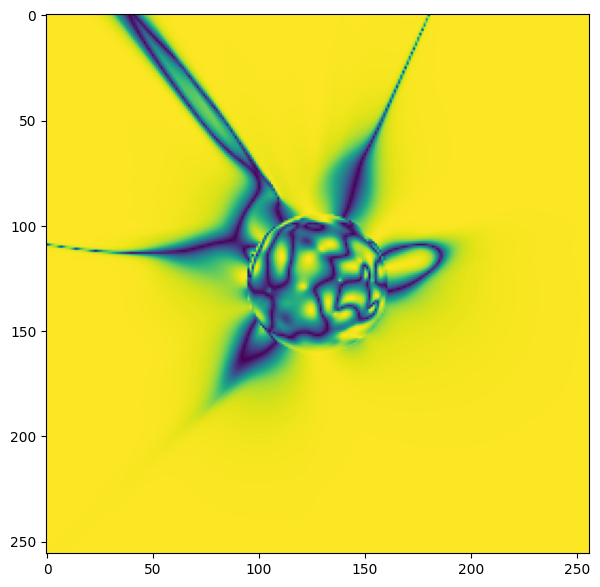

In [47]:
plt.figure()
plt.imshow(data['quantmap'].DATA[0][::-1], aspect='auto')
plt.show()

In [52]:
for item in data['obspramsstruct'].item():
    print(item)

b'PHYSICAL DIAGNOSTICS'
b'VR'
-99
b'Vr (km/sec)'
b'NONE'
b'2012-01-04'
-1.0
0.0
0
0
0
b'NULL'
0
0
0
[(1, b'tog', b'sun_coronal_2021_chianti', b'nodisplay', '', b'nodisplay', b'10*1', b'nodisplay', '', b'nodisplay', '', b'nodisplay', 0, b'nodisplay', 0., b'nodisplay', 0., b'nodisplay', '', b'nodisplay', '', b'nodisplay', 100., b'nodisplay', 0, b'nodisplay', 1, b'nodisplay', 1., b'nodisplay', 1., b'nodisplay', 1., b'nodisplay', 0., b'nodisplay', 0., b'nodisplay', 0., b'nodisplay', 0., b'nodisplay', 0., b'nodisplay', b'sun_coronal_2021_chianti', b'nodisplay', b'/net/maedoc.ap.dias.ie/maedoc/home_cr/mnedal/ssw/packages/forward/idl/DEFAULTS/simpleionfrac.genx', b'nodisplay')]
[(0, b'tog', 0., b'double', 29.9884375, b'nodisplay', 300., b'double', 1., b'double', 1., b'double', 0., b'double', 0., b'double', 1., b'double', b'COMP', b'nodisplay', 0, b'nodisplay')]
[(1, b'tog', 0., b'nodisplay', 0., b'nodisplay', 0., b'nodisplay', 0., b'double', 0., b'nodisplay', 0., b'nodisplay', 0, b'nodisplay'

In [48]:
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord
import sunpy.map
from sunpy.coordinates import frames

In [ ]:
b = {name:nrh['nrh_hdr'][name][image_index] for name in nrh['nrh_hdr'].dtype.names}

In [80]:
for name in data.gridpramsstruct.item():
    print(name)

b'PLANEOFSKY'
0.0
b'Cmer'
[[5.63475716 5.61270357 5.59073767 ... 5.59073767 5.61270357 5.63475716]
 [5.61270357 5.59056299 5.56850975 ... 5.56850975 5.59056299 5.61270357]
 [5.59073767 5.56850975 5.54636881 ... 5.54636881 5.56850975 5.59073767]
 ...
 [5.59073767 5.56850975 5.54636881 ... 5.54636881 5.56850975 5.59073767]
 [5.61270357 5.59056299 5.56850975 ... 5.56850975 5.59056299 5.61270357]
 [5.63475716 5.61270357 5.59073767 ... 5.59073767 5.61270357 5.63475716]]
[[2.35619449 2.36013148 2.36409946 ... 3.91908584 3.92305383 3.92699082]
 [2.3522575  2.35619449 2.36016272 ... 3.92302258 3.92699082 3.9309278 ]
 [2.34828952 2.35222626 2.35619449 ... 3.92699082 3.93095905 3.93489579]
 ...
 [0.79330314 0.7893664  0.78539816 ... 5.49778714 5.49381891 5.48988217]
 [0.78933515 0.78539816 0.78142993 ... 5.50175538 5.49778714 5.49385016]
 [0.78539816 0.78146118 0.77749319 ... 5.50569212 5.50172413 5.49778714]]
[[1.3656489 1.3656489 1.3656489 ... 1.3656489 1.3656489 1.3656489]
 [1.3656489 1.36564

In [ ]:
# # getting header info for a given time index
# b = {name:nrh['nrh_hdr'][name][image_index] for name in nrh['nrh_hdr'].dtype.names}

# # Constuct the NRH image
# map_data = nrh['nrh_data'][image_index]

# ref_coord = SkyCoord(0*u.arcsec, 0*u.arcsec, 
#                      frame=frames.Helioprojective(observer='earth', obstime=b['DATE_OBS'])
#                      )
# header = sunpy.map.make_fitswcs_header(map_data,
#                                        ref_coord,
#                                        reference_pixel=[int(b['CRPIX1'])-1, int(b['CRPIX2'])-1]*u.pixel,
#                                        scale=[float(b['CDELT1']), float(b['CDELT2'])]*u.arcsec/u.pixel,
#                                        wavelength=float(b['FREQ'])*u.MHz)
# nrh_map = sunpy.map.Map(map_data, header)

In [ ]:
coord = SkyCoord(0*u.arcsec, 0*u.arcsec, obstime=obs_date, observer='earth', frame=frames.Helioprojective)

In [44]:
# List all variables and their types
for item in data['quantmap'].item():
    print(item)

[[9.95905305e-11 9.95680793e-11 9.95626595e-11 ... 9.99239438e-11
  9.99247171e-11 9.99254413e-11]
 [9.96311675e-11 9.95860303e-11 9.95633678e-11 ... 9.99224150e-11
  9.99231433e-11 9.99238537e-11]
 [9.96695713e-11 9.96271557e-11 9.95815280e-11 ... 9.99208419e-11
  9.99215089e-11 9.99222107e-11]
 ...
 [9.99742386e-11 9.99763125e-11 9.99780183e-11 ... 9.99178255e-11
  9.99176320e-11 9.99174412e-11]
 [9.99756783e-11 9.99770999e-11 9.99780336e-11 ... 9.99194542e-11
  9.99193394e-11 9.99191743e-11]
 [9.99758618e-11 9.99764386e-11 9.99762765e-11 ... 9.99209766e-11
  9.99209736e-11 9.99208578e-11]]
0.0
0.0
0.03125
0.03125
b'2012-01-04'
b'2118_HMI_THERMO_MED_H2.dat!cVr 2460556.5459259'
0.0
b'RSun'
b'RSun'
0.0
[0. 0.]
b'km/sec'
b'disk'
-3.2937190532684326
[-3.61038838e-06]
78.24591827392578
215.0
b'Cmer'
1.0
b'psimas_PHYSICAL DIAGNOSTICS_VR_2460556.5459259'
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 